# Method 7 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

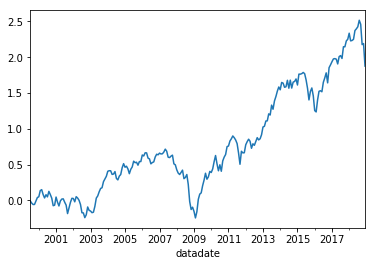

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.038715
2000-12-31   -0.103482
2001-12-31    0.103431
2002-12-31   -0.163970
2003-12-31    0.554678
2004-12-31    0.131970
2005-12-31    0.019383
2006-12-31    0.061469
2007-12-31   -0.085729
2008-12-31   -0.396087
2009-12-31    0.554287
2010-12-31    0.246563
2011-12-31   -0.048930
2012-12-31    0.151064
2013-12-31    0.348467
2014-12-31    0.043430
2015-12-31   -0.087353
2016-12-31    0.175697
2017-12-31    0.123644
2018-12-31   -0.115413
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1006.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.40e-144
Time:                        21:39:20   Log-Likelihood:                 705.20
No. Observations:                 234   AIC:                            -1400.
Df Residuals:                     229   BIC:                            -1383.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.364      0.019       0.000       0.004
mktrf          0.8568      0.022     38.245      0.000       0.813       0.901
me             0.3790      0.026     14.544      0.000       0.328       0.430
ia             0.2142      0.040      5.408      0.000       0.136       0.292
roe           -0.3941      0.034    -11.623      0.000      -0.461      -0.327
==============================================================================
Omnibus:                       56.219   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.428
Skew:                           0.746   Prob(JB):                     2.19e-76
Kurtosis:                       8.789   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1000.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.03e-143
Time:                        21:39:20   Log-Likelihood:                 705.20
No. Observations:                 234   AIC:                            -1400.
Df Residuals:                     229   BIC:                            -1383.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.894      0.058   -6.73e-05       0.004
mktrf          0.8568      0.033     25.912      0.000       0.792       0.922
me             0.3790      0.083      4.579      0.000       0.217       0.541
ia             0.2142      0.082      2.600      0.009       0.053       0.376
roe           -0.3941      0.061     -6.436      0.000      -0.514      -0.274
==============================================================================
Omnibus:                       56.219   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.428
Skew:                           0.746   Prob(JB):                     2.19e-76
Kurtosis:                       8.789   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1350.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.88e-158
Time:                        21:39:20   Log-Likelihood:                 705.20
No. Observations:                 234   AIC:                            -1400.
Df Residuals:                     229   BIC:                            -1383.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.743      0.081      -0.000       0.004
mktrf          0.8568      0.028     31.099      0.000       0.803       0.911
me             0.3790      0.089      4.267      0.000       0.205       0.553
ia             0.2142      0.078      2.757      0.006       0.062       0.366
roe           -0.3941      0.056     -7.052      0.000      -0.504      -0.285
==============================================================================
Omnibus:                       56.219   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.428
Skew:                           0.746   Prob(JB):                     2.19e-76
Kurtosis:                       8.789   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     614.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.98e-130
Time:                        21:39:20   Log-Likelihood:                 676.01
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     228   BIC:                            -1319.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.807      0.420      -0.001       0.003
mktrf          0.9276      0.025     36.397      0.000       0.877       0.978
smb            0.4851      0.034     14.425      0.000       0.419       0.551
hml            0.1836      0.040      4.631      0.000       0.105       0.262
rmw           -0.1722      0.045     -3.841      0.000      -0.261      -0.084
cma           -0.0106      0.057     -0.185      0.853      -0.123       0.102
==============================================================================
Omnibus:                      101.541   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.716
Skew:                           1.545   Prob(JB):                    1.39e-151
Kurtosis:                      10.855   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     383.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.49e-109
Time:                        21:39:20   Log-Likelihood:                 676.01
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     228   BIC:                            -1319.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.672      0.501      -0.001       0.003
mktrf          0.9276      0.028     33.236      0.000       0.873       0.982
smb            0.4851      0.071      6.839      0.000       0.346       0.624
hml            0.1836      0.064      2.858      0.004       0.058       0.310
rmw           -0.1722      0.066     -2.614      0.009      -0.301      -0.043
cma           -0.0106      0.106     -0.100      0.920      -0.217       0.196
==============================================================================
Omnibus:                      101.541   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.716
Skew:                           1.545   Prob(JB):                    1.39e-151
Kurtosis:                      10.855   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     459.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.20e-117
Time:                        21:39:20   Log-Likelihood:                 676.01
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     228   BIC:                            -1319.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.606      0.545      -0.002       0.003
mktrf          0.9276      0.026     35.993      0.000       0.877       0.978
smb            0.4851      0.067      7.294      0.000       0.355       0.615
hml            0.1836      0.062      2.982      0.003       0.063       0.304
rmw           -0.1722      0.068     -2.536      0.011      -0.305      -0.039
cma           -0.0106      0.111     -0.095      0.924      -0.228       0.207
==============================================================================
Omnibus:                      101.541   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.716
Skew:                           1.545   Prob(JB):                    1.39e-151
Kurtosis:                      10.855   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1391.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.41e-159
Time:                        21:39:20   Log-Likelihood:                 741.33
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1455.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.806      0.072      -0.000       0.003
mktrf          0.8687      0.018     49.146      0.000       0.834       0.904
smb            0.5884      0.022     26.668      0.000       0.545       0.632
hml            0.1743      0.022      7.952      0.000       0.131       0.217
umd           -0.2123      0.014    -14.759      0.000      -0.241      -0.184
==============================================================================
Omnibus:                       19.933   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.090
Skew:                           0.474   Prob(JB):                     2.40e-08
Kurtosis:                       4.644   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1470.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.66e-162
Time:                        21:39:20   Log-Likelihood:                 741.33
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1455.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.545      0.122      -0.000       0.003
mktrf          0.8687      0.017     50.189      0.000       0.835       0.903
smb            0.5884      0.048     12.311      0.000       0.495       0.682
hml            0.1743      0.033      5.335      0.000       0.110       0.238
umd           -0.2123      0.026     -8.102      0.000      -0.264      -0.161
==============================================================================
Omnibus:                       19.933   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.090
Skew:                           0.474   Prob(JB):                     2.40e-08
Kurtosis:                       4.644   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1571.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.63e-165
Time:                        21:39:20   Log-Likelihood:                 741.33
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1455.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.439      0.150      -0.000       0.003
mktrf          0.8687      0.016     55.283      0.000       0.838       0.900
smb            0.5884      0.048     12.170      0.000       0.494       0.683
hml            0.1743      0.034      5.065      0.000       0.107       0.242
umd           -0.2123      0.024     -8.837      0.000      -0.259      -0.165
==============================================================================
Omnibus:                       19.933   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.090
Skew:                           0.474   Prob(JB):                     2.40e-08
Kurtosis:                       4.644   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     414.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.56e-67
Time:                        21:39:20   Log-Likelihood:                 334.73
No. Observations:                 120   AIC:                            -659.5
Df Residuals:                     115   BIC:                            -645.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.229      0.028       0.000       0.006
mktrf          0.8617      0.039     22.009      0.000       0.784       0.939
me             0.3154      0.039      8.155      0.000       0.239       0.392
ia             0.2416      0.061      3.989      0.000       0.122       0.362
roe           -0.4146      0.054     -7.736      0.000      -0.521      -0.308
==============================================================================
Omnibus:                       19.306   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.230
Skew:                           0.607   Prob(JB):                     4.10e-10
Kurtosis:                       5.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     343.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-63
Time:                        21:39:20   Log-Likelihood:                 334.73
No. Observations:                 120   AIC:                            -659.5
Df Residuals:                     115   BIC:                            -645.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.811      0.070      -0.000       0.007
mktrf          0.8617      0.048     17.795      0.000       0.767       0.957
me             0.3154      0.087      3.635      0.000       0.145       0.485
ia             0.2416      0.097      2.497      0.013       0.052       0.431
roe           -0.4146      0.074     -5.605      0.000      -0.560      -0.270
==============================================================================
Omnibus:                       19.306   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.230
Skew:                           0.607   Prob(JB):                     4.10e-10
Kurtosis:                       5.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     374.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.87e-65
Time:                        21:39:20   Log-Likelihood:                 334.73
No. Observations:                 120   AIC:                            -659.5
Df Residuals:                     115   BIC:                            -645.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.634      0.102      -0.001       0.007
mktrf          0.8617      0.041     21.034      0.000       0.781       0.942
me             0.3154      0.095      3.320      0.001       0.129       0.501
ia             0.2416      0.092      2.623      0.009       0.061       0.422
roe           -0.4146      0.063     -6.615      0.000      -0.537      -0.292
==============================================================================
Omnibus:                       19.306   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.230
Skew:                           0.607   Prob(JB):                     4.10e-10
Kurtosis:                       5.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     250.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.49e-60
Time:                        21:39:20   Log-Likelihood:                 319.60
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.376      0.172      -0.001       0.006
mktrf          0.9917      0.047     21.081      0.000       0.899       1.085
smb            0.4513      0.053      8.470      0.000       0.346       0.557
hml            0.1654      0.065      2.533      0.013       0.036       0.295
rmw           -0.1431      0.077     -1.858      0.066      -0.296       0.009
cma            0.0235      0.084      0.279      0.781      -0.144       0.191
==============================================================================
Omnibus:                       41.514   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.102
Skew:                           1.228   Prob(JB):                     9.25e-29
Kurtosis:                       7.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     214.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.28e-56
Time:                        21:39:20   Log-Likelihood:                 319.60
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.175      0.240      -0.002       0.006
mktrf          0.9917      0.047     21.270      0.000       0.900       1.083
smb            0.4513      0.092      4.908      0.000       0.271       0.631
hml            0.1654      0.087      1.901      0.057      -0.005       0.336
rmw           -0.1431      0.085     -1.676      0.094      -0.310       0.024
cma            0.0235      0.126      0.187      0.851      -0.223       0.270
==============================================================================
Omnibus:                       41.514   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.102
Skew:                           1.228   Prob(JB):                     9.25e-29
Kurtosis:                       7.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     301.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.49e-64
Time:                        21:39:20   Log-Likelihood:                 319.60
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.057      0.291      -0.002       0.007
mktrf          0.9917      0.045     21.937      0.000       0.903       1.080
smb            0.4513      0.084      5.386      0.000       0.287       0.616
hml            0.1654      0.085      1.940      0.052      -0.002       0.332
rmw           -0.1431      0.085     -1.678      0.093      -0.310       0.024
cma            0.0235      0.130      0.181      0.856      -0.231       0.278
==============================================================================
Omnibus:                       41.514   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.102
Skew:                           1.228   Prob(JB):                     9.25e-29
Kurtosis:                       7.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     627.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-77
Time:                        21:39:20   Log-Likelihood:                 358.23
No. Observations:                 120   AIC:                            -706.5
Df Residuals:                     115   BIC:                            -692.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.049      0.043    7.93e-05       0.005
mktrf          0.8881      0.028     31.315      0.000       0.832       0.944
smb            0.5756      0.032     17.826      0.000       0.512       0.640
hml            0.1862      0.032      5.757      0.000       0.122       0.250
umd           -0.2209      0.020    -11.079      0.000      -0.260      -0.181
==============================================================================
Omnibus:                        3.559   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.966
Skew:                           0.324   Prob(JB):                        0.227
Kurtosis:                       3.415   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     844.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.24e-84
Time:                        21:39:20   Log-Likelihood:                 358.23
No. Observations:                 120   AIC:                            -706.5
Df Residuals:                     115   BIC:                            -692.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.915      0.056   -5.67e-05       0.005
mktrf          0.8881      0.025     35.599      0.000       0.839       0.937
smb            0.5756      0.055     10.557      0.000       0.469       0.682
hml            0.1862      0.046      4.062      0.000       0.096       0.276
umd           -0.2209      0.030     -7.411      0.000      -0.279      -0.162
==============================================================================
Omnibus:                        3.559   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.966
Skew:                           0.324   Prob(JB):                        0.227
Kurtosis:                       3.415   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1253.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.62e-94
Time:                        21:39:20   Log-Likelihood:                 358.23
No. Observations:                 120   AIC:                            -706.5
Df Residuals:                     115   BIC:                            -692.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.841      0.066      -0.000       0.005
mktrf          0.8881      0.021     41.808      0.000       0.846       0.930
smb            0.5756      0.055     10.436      0.000       0.467       0.684
hml            0.1862      0.049      3.793      0.000       0.090       0.282
umd           -0.2209      0.028     -7.857      0.000      -0.276      -0.166
==============================================================================
Omnibus:                        3.559   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.966
Skew:                           0.324   Prob(JB):                        0.227
Kurtosis:                       3.415   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1424.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.43e-93
Time:                        21:39:20   Log-Likelihood:                 426.00
No. Observations:                 114   AIC:                            -842.0
Df Residuals:                     109   BIC:                            -828.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.309      0.023       0.000       0.003
mktrf          0.8154      0.017     47.033      0.000       0.781       0.850
me             0.5638      0.027     21.062      0.000       0.511       0.617
ia             0.1194      0.037      3.215      0.002       0.046       0.193
roe           -0.3758      0.033    -11.519      0.000      -0.440      -0.311
==============================================================================
Omnibus:                        2.800   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.467
Skew:                           0.163   Prob(JB):                        0.291
Kurtosis:                       3.643   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2504.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.07e-106
Time:                        21:39:20   Log-Likelihood:                 426.00
No. Observations:                 114   AIC:                            -842.0
Df Residuals:                     109   BIC:                            -828.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.412      0.016       0.000       0.002
mktrf          0.8154      0.014     57.502      0.000       0.788       0.843
me             0.5638      0.030     18.816      0.000       0.505       0.623
ia             0.1194      0.041      2.920      0.003       0.039       0.199
roe           -0.3758      0.050     -7.540      0.000      -0.473      -0.278
==============================================================================
Omnibus:                        2.800   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.467
Skew:                           0.163   Prob(JB):                        0.291
Kurtosis:                       3.643   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3570.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-114
Time:                        21:39:20   Log-Likelihood:                 426.00
No. Observations:                 114   AIC:                            -842.0
Df Residuals:                     109   BIC:                            -828.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.111      0.002       0.001       0.002
mktrf          0.8154      0.014     58.081      0.000       0.788       0.843
me             0.5638      0.031     18.351      0.000       0.504       0.624
ia             0.1194      0.045      2.668      0.008       0.032       0.207
roe           -0.3758      0.054     -7.012      0.000      -0.481      -0.271
==============================================================================
Omnibus:                        2.800   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.467
Skew:                           0.163   Prob(JB):                        0.291
Kurtosis:                       3.643   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     737.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-81
Time:                        21:39:20   Log-Likelihood:                 402.29
No. Observations:                 114   AIC:                            -792.6
Df Residuals:                     108   BIC:                            -776.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.053e-05      0.001      0.014      0.989      -0.001       0.001
mktrf          0.8483      0.020     41.481      0.000       0.808       0.889
smb            0.5889      0.033     17.739      0.000       0.523       0.655
hml            0.1309      0.042      3.092      0.003       0.047       0.215
rmw           -0.2030      0.052     -3.915      0.000      -0.306      -0.100
cma            0.0365      0.066      0.555      0.580      -0.094       0.167
==============================================================================
Omnibus:                       15.141   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.660
Skew:                           0.710   Prob(JB):                     5.38e-05
Kurtosis:                       4.457   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1290.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-94
Time:                        21:39:21   Log-Likelihood:                 402.29
No. Observations:                 114   AIC:                            -792.6
Df Residuals:                     108   BIC:                            -776.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.053e-05      0.001      0.013      0.989      -0.002       0.002
mktrf          0.8483      0.013     63.067      0.000       0.822       0.875
smb            0.5889      0.031     19.215      0.000       0.529       0.649
hml            0.1309      0.057      2.294      0.022       0.019       0.243
rmw           -0.2030      0.068     -2.977      0.003      -0.337      -0.069
cma            0.0365      0.061      0.596      0.551      -0.084       0.157
==============================================================================
Omnibus:                       15.141   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.660
Skew:                           0.710   Prob(JB):                     5.38e-05
Kurtosis:                       4.457   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1961.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.14e-104
Time:                        21:39:21   Log-Likelihood:                 402.29
No. Observations:                 114   AIC:                            -792.6
Df Residuals:                     108   BIC:                            -776.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.053e-05      0.001      0.013      0.989      -0.002       0.002
mktrf          0.8483      0.014     60.153      0.000       0.821       0.876
smb            0.5889      0.033     17.904      0.000       0.524       0.653
hml            0.1309      0.053      2.456      0.014       0.026       0.235
rmw           -0.2030      0.072     -2.818      0.005      -0.344      -0.062
cma            0.0365      0.066      0.557      0.578      -0.092       0.165
==============================================================================
Omnibus:                       15.141   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.660
Skew:                           0.710   Prob(JB):                     5.38e-05
Kurtosis:                       4.457   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1084.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.42e-87
Time:                        21:39:21   Log-Likelihood:                 410.75
No. Observations:                 114   AIC:                            -811.5
Df Residuals:                     109   BIC:                            -797.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.260      0.796      -0.001       0.002
mktrf          0.8454      0.019     45.017      0.000       0.808       0.883
smb            0.6456      0.029     22.048      0.000       0.588       0.704
hml            0.1589      0.030      5.269      0.000       0.099       0.219
umd           -0.1429      0.023     -6.283      0.000      -0.188      -0.098
==============================================================================
Omnibus:                       10.518   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.067
Skew:                           0.366   Prob(JB):                     0.000119
Kurtosis:                       4.808   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1173.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-88
Time:                        21:39:21   Log-Likelihood:                 410.75
No. Observations:                 114   AIC:                            -811.5
Df Residuals:                     109   BIC:                            -797.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.255      0.799      -0.001       0.002
mktrf          0.8454      0.015     56.998      0.000       0.816       0.874
smb            0.6456      0.031     20.943      0.000       0.585       0.706
hml            0.1589      0.040      3.984      0.000       0.081       0.237
umd           -0.1429      0.021     -6.716      0.000      -0.185      -0.101
==============================================================================
Omnibus:                       10.518   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.067
Skew:                           0.366   Prob(JB):                     0.000119
Kurtosis:                       4.808   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1479.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.94e-94
Time:                        21:39:21   Log-Likelihood:                 410.75
No. Observations:                 114   AIC:                            -811.5
Df Residuals:                     109   BIC:                            -797.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.239      0.811      -0.001       0.002
mktrf          0.8454      0.014     62.259      0.000       0.819       0.872
smb            0.6456      0.030     21.852      0.000       0.588       0.704
hml            0.1589      0.038      4.133      0.000       0.084       0.234
umd           -0.1429      0.018     -7.825      0.000      -0.179      -0.107
==============================================================================
Omnibus:                       10.518   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.067
Skew:                           0.366   Prob(JB):                     0.000119
Kurtosis:                       4.808   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""